In [31]:
from scipy.misc import comb
import math

In [2]:
def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2.))
    probs =[comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k)
           for k in range(k_start,n_classifier+1)]
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11,error=0.25)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  after removing the cwd from sys.path.


0.03432750701904297

In [4]:
import numpy as np
import matplotlib.pyplot as plt

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  after removing the cwd from sys.path.


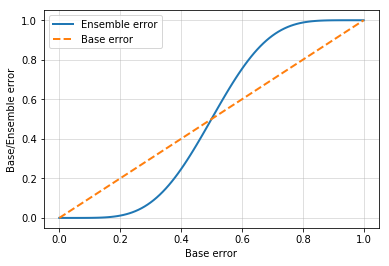

In [6]:
error_range = np.arange(0.0,1.01,0.01)
ens_errors =[ensemble_error(n_classifier=11,error=error)
            for error in error_range]

plt.plot(error_range,ens_errors,label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,linestyle="--",label="Base error",linewidth=2)
plt.xlabel("Base error")
plt.ylabel("Base/Ensemble error")
plt.legend(loc="upper left")
plt.grid(alpha=0.5)
plt.show()

In [7]:
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

In [9]:
ex = np.array([[0.9,0.1],[0.8,0.2],[0.4,0.6]])
p = np.average(ex,axis=0,weights=[0.2,0.2,0.6])
p
np.argmax(p)

0

In [10]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

In [11]:
#多数決アンサンブル分類器
class MajorVoteClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self,classifiers,vote="classlabel",weights=None):
        self.classifiers = classifiers
        self.named_classifiers ={key : value for key,value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self,X,y):
        #LabelEncoderを使ってクラスラベルが０から始まるようにエンコードする
        #self.predictのnp.argmax呼び出しで重要となる
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes = self.lablenc_.classes
        self.classifiers_=[]
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self,lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        #Xのクラス「ラベル」を予測する
        
        #戻り値maj_voteは予測されたクラスラベル
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else:#'class label'での多数決
            
            #clf.predict呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            #各サンプルのクラス確率に重みをかけて足し合わせた値が最大となる列番号を配列として返す
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
        
        #各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote=self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        #Xのクラス確率を予測する
        
        #戻り値avg_probaは各サンプルに対する各クラスで重みづけた平均確率
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas,axis=0,weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        #グリッドサーチの実行後に分類器のパラメータを取得
        if not deep:
            return super(MajorVoteClassifier,self).get_params(deep=False)
        else:
            #キーを"分類器の名前＿パラメータ名"
            #バリューをパラメータの値とするディクショナリを生成
            out = self.named_classifiers.copy()
            for name,step in six.iteritems(self.named_classifiers):
                for key ,value in six.iteritems(step.get_params(deep=True)):
                    out["%__%s"% (name,key)]=value
            return out

In [12]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [14]:
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [28]:
clf1 = LogisticRegression(penalty="l2",C=0.001,random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,criterion="entropy",random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric="minkowski")
pipe1 = Pipeline([["sc",StandardScaler()],["clf",clf1]])
pipe3 = Pipeline([["sc",StandardScaler()],["clf",clf3]])
clf_labels = ["LogisticRegression","Decision tree","KNN"]
print("10-fold cross validation:\n")
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring="roc_auc")
    print("ROC AUC: %0.2f(+/-%0.2f)[%s]"%(scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC: 0.87(+/-0.17)[LogisticRegression]
ROC AUC: 0.89(+/-0.16)[Decision tree]
ROC AUC: 0.88(+/-0.15)[KNN]


/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [33]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ["Majority voting"]
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring="roc_auc")
    print("ROC AUC: %0.2f(+/-%0.2f)[%s]"%(scores.mean(),scores.std(),label))

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

ROC AUC: 0.87(+/-0.17)[LogisticRegression]
ROC AUC: 0.89(+/-0.16)[Decision tree]
ROC AUC: 0.88(+/-0.15)[KNN]
ROC AUC: 0.94(+/-0.13)[Majority voting]


/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

7.3

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


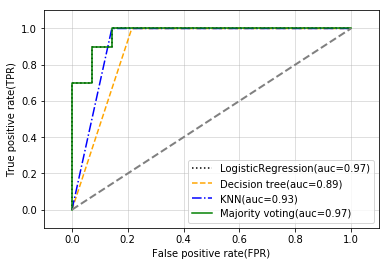

In [110]:
colors =["black","orange","blue","green"]
linestyles = [":","--","-.","-"]
for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    #陽性クラスのラベルは１であることが前提
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr,tpr,thresholds=roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label="%s(auc=%0.2f)"%(label,roc_auc))
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],linestyle="--",color="gray",linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel("False positive rate(FPR)")
plt.ylabel("True positive rate(TPR)")
plt.show()

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


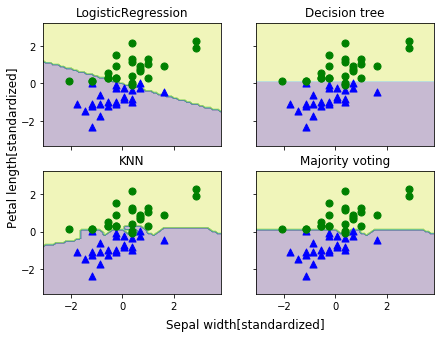

In [40]:
sc =StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
#決定領域を描画する最小値、最大値を生成
x_min=X_train_std[:,0].min()-1
x_max=X_train_std[:,0].max()+1
y_min=X_train_std[:,1].min()-1
y_max=X_train_std[:,1].max()+1
#グリッドポイントを生成
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                   np.arange(y_min,y_max,0.1))
#描画領域を2行2列に分割
f,axarr = plt.subplots(nrows=2,ncols=2,sharex="col",sharey="row",figsize=(7,5))
#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列の位置を表すタプル
for idx,clf,tt in zip(product([0,1],[0,1]),all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,z,alpha=0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                X_train_std[y_train==0,1],c="blue",marker="^",s=50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                X_train_std[y_train==1,1],c="green",marker="o",s=50)
    axarr[idx[0],idx[1]].set_title(tt)
    
plt.text(-3.5,-5.,s="Sepal width[standardized]",ha="center",va="center",fontsize=12)
plt.text(-12.5,4.5,s="Petal length[standardized]",ha="center",va="center",fontsize=12,rotation=90)
plt.show()

In [41]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [42]:
from sklearn.model_selection import GridSearchCV

In [53]:
params ={"decisiontreeclassifier__max_depth":[1,2],
        "pipeline-1__clf__C":[0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring="roc_auc")
grid.fit(X_train,y_train)
for r ,_ in enumerate(grid.cv_results_["mean_test_score"]):
    print("%0.3f +/- %0.2f %r"%(grid.cv_results_["mean_test_score"][r],
                               grid.cv_results_["std_test_score"][r]/2.0,
                               grid.cv_results_["params"][r]))

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.933 +/- 0.07 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.947 +/- 0.07 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
0.973 +/- 0.04 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.947 +/- 0.07 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.947 +/- 0.07 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
0.973 +/- 0.04 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [54]:
print("Best parameters: %s"%grid.best_params_)

Best parameters: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}


In [55]:
print("Accuracy:%.2f"%grid.best_score_)

Accuracy:0.97


7.4

In [57]:
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',header=None)
df_wine.columns=['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
#クラス１を削除
df_wine =df_wine[df_wine["Class label"]!=1]
y=df_wine["Class label"].values
X = df_wine[["Alcohol","OD280/OD315 of diluted wines"]].values

In [58]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [59]:
from sklearn.ensemble import BaggingClassifier
tree =DecisionTreeClassifier(criterion="entropy",max_depth=None,random_state=1)
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0,max_features=1.0,
                       bootstrap =True,bootstrap_features=False,n_jobs=-1,random_state=1)

In [60]:
from sklearn.metrics import accuracy_score

In [61]:
tree = tree.fit(X_train,y_train)
y_train_pred=tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print("Decision tree train/test accuracies %.3f/%.3f"%(tree_train,tree_test))

Decision tree train/test accuracies 1.000/0.833


In [62]:
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print("Bagging train/test accuracies %.3f/%.3f"%(bag_train,bag_test))

Bagging train/test accuracies 1.000/0.917


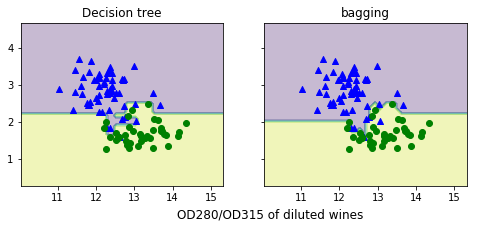

In [70]:
#決定領域を描画する最小値、最大値を生成
x_min=X_train[:,0].min()-1
x_max=X_train[:,0].max()+1
y_min=X_train[:,1].min()-1
y_max=X_train[:,1].max()+1
#グリッドポイントを生成
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                   np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(nrows=1,ncols=2,sharex="col",sharey="row",figsize=(8,3))
#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列の位置を表すタプル
for idx,clf,tt in zip([0,1],[tree,bag],["Decision tree","bagging"]):
    clf.fit(X_train,y_train)
    z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                                X_train[y_train==0,1],c="blue",marker="^")
    axarr[idx].scatter(X_train[y_train==1,0],
                                X_train[y_train==1,1],c="green",marker="o")
    axarr[idx].set_title(tt)
    
plt.text(10.2,-0.5,s="OD280/OD315 of diluted wines",ha="center",va="center",fontsize=12)
plt.show()

In [71]:
from sklearn.ensemble import AdaBoostClassifier

In [72]:
tree = DecisionTreeClassifier(criterion="entropy",max_depth=1,random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print("Bagging train/test accuracies %.3f/%.3f"%(tree_train,tree_test))

Bagging train/test accuracies 0.916/0.875


In [73]:
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print("Bagging train/test accuracies %.3f/%.3f"%(ada_train,ada_test))

Bagging train/test accuracies 1.000/0.917


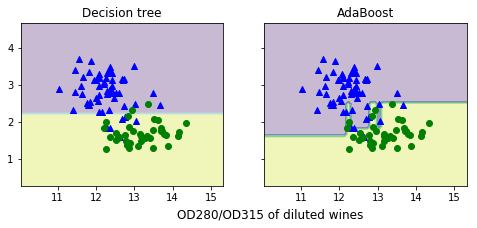

In [74]:
#決定領域を描画する最小値、最大値を生成
x_min=X_train[:,0].min()-1
x_max=X_train[:,0].max()+1
y_min=X_train[:,1].min()-1
y_max=X_train[:,1].max()+1
#グリッドポイントを生成
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                   np.arange(y_min,y_max,0.1))
f,axarr = plt.subplots(1,2,sharex="col",sharey="row",figsize=(8,3))
#決定領域のプロット、青や赤の散布図の作成などを実行
#変数idxは各分類器を描画する行と列の位置を表すタプル
for idx,clf,tt in zip([0,1],[tree,ada],["Decision tree","AdaBoost"]):
    clf.fit(X_train,y_train)
    z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    z = z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,z,alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                                X_train[y_train==0,1],c="blue",marker="^")
    axarr[idx].scatter(X_train[y_train==1,0],
                                X_train[y_train==1,1],c="green",marker="o")
    axarr[idx].set_title(tt)
    
plt.text(10.2,-0.5,s="OD280/OD315 of diluted wines",ha="center",va="center",fontsize=12)
plt.show()

In [103]:
 def dobule(x):
        print(x*2)
        return x * 2

In [104]:
A = np.arange(6).reshape((3,2))

In [100]:
A

array([[0, 1],
       [2, 3],
       [4, 5]])

In [107]:
np.apply_along_axis(dobule, 0, A)

[0 4 8]
[ 2  6 10]


array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

In [102]:
np.apply_along_axis(dobule, 1, A)

[0 1] 

[0 2]
[2 3] 

[4 6]
[4 5] 

[ 8 10]


array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])